# MSDS 631 Final Project
## Mask Classification

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# model architecture
import torchvision
from torchvision import models, transforms

### Creating data info dataframe

In [2]:
path = '/Users/matthewhui/classes/deep_learning/MSDS631_FinalProject/New Masks Dataset'

def get_info(path, info, label, dataset):
    """Get info of all images in specified path"""
    for img in os.listdir(path):
        row = {} 
        row['dataset'] = dataset
        row['image_path'] = f'{path}/{img}'
        row['image'] = img
        row['label'] = label
        info.append(row)
    return info 

info = [] 
info = get_info(f'{path}/Train/Mask', info, 'mask', 'train')
info = get_info(f'{path}/Train/Non Mask', info, 'no mask', 'train')
info = get_info(f'{path}/Validation/Mask', info, 'mask', 'valid')
info = get_info(f'{path}/Validation/Non Mask', info, 'no mask', 'valid')
info = get_info(f'{path}/Test/Mask', info, 'mask', 'test')
info = get_info(f'{path}/Test/Non Mask', info, 'no mask', 'test')
info_df = pd.DataFrame(info)
# Save dataframe
info_df.to_csv('/Users/matthewhui/classes/deep_learning/MSDS631_FinalProject/New Masks Dataset/data_info.csv', index=False)
info_df.head()

,dataset,image_path,image,label
0,train,/Users/matthewhui/classes/deep_learning/MSDS63...,1409.jpg,mask
1,train,/Users/matthewhui/classes/deep_learning/MSDS63...,0515.png,mask
2,train,/Users/matthewhui/classes/deep_learning/MSDS63...,0930.jpg,mask
3,train,/Users/matthewhui/classes/deep_learning/MSDS63...,0273.jpg,mask
4,train,/Users/matthewhui/classes/deep_learning/MSDS63...,0267.jpg,mask


### Preprocess Images (Resize)

In [49]:
for img_path in info_df.image_path: 
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    cv2.imwrite(img_path, img)

### Creating Dataset Class

In [50]:
class MaskDataset(Dataset):
    def __init__(self, df): 
        self.df = df 
        self.mask_dict = {'no mask': 0, 'mask': 1}
        self.transformations = A.Compose([
            # Spatial Transformations 
            A.HorizontalFlip(),
            A.VerticalFlip(), 
            A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.75),
            
            # Pixel Transformations
            A.RandomBrightnessContrast(p=0.5),
            
            ToTensorV2()   
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Read in Image and Convert/Transform
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        img_transform = self.transformations(image=img.astype(np.uint8))
        img_transform = img_transform['image']
        img_transform = torch.tensor(img_transform / 255.).float()
        
        label = torch.tensor(self.mask_dict[row.label])
        
        return img_transform, label
        

In [51]:
# Creating Training/Validation Datasets and DataLoaders 
train_df = info_df[info_df['dataset'] == 'train'].reset_index(drop=True)
valid_df = info_df[info_df['dataset'] == 'valid'].reset_index(drop=True)

train_ds = MaskDataset(train_df)
valid_ds = MaskDataset(valid_df)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=True)

In [52]:
# Test the Dataset class is working properly 
img, label = next(iter(train_ds))
print(f'Dataset image dimensions: {img.shape}')
img = np.transpose(np.array(img), (1,2,0))
print(f'After transformation image dimensions: {img.shape}')
plt.imshow(img)
plt.title(label) # 1: mask, 0: no mask
plt.axis('off')

Dataset image dimensions: torch.Size([3, 128, 128])
After transformation image dimensions: (128, 128, 3)


<ipython-input-50-bf271bb8d9ef>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


(-0.5, 127.5, 127.5, -0.5)

<Figure size 432x288 with 1 Axes>

### Fitting Models
* CNN (from Scratch) 
* AlexNet (frozen / finetuned)
* ResNet 

In [53]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

#### Convolutional Neural Network (CNN)

In [54]:
class MaskCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(4096, 100)
        self.linear2 = nn.Linear(100, 2) # 2 output classes
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.relu = nn.ReLU()
        
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.relu(self.linear1(self.unroll(x)))
        x = self.linear2(x)
        return x

In [55]:
model = MaskCNN()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [56]:
summary(model, input_size = (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
              ReLU-2          [-1, 8, 128, 128]               0
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
              ReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
              ReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

In [57]:
# Train and Validate Model for 5 epochs
train_losses = []
valid_losses = []

for epoch in range(5):
    print(f'Epoch: {epoch}')
    
    train_loss = one_pass(model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print(f'Train loss: {train_loss}')
    
    valid_loss = one_pass(model, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print(f'Valid loss: {valid_loss}')
    
    train_acc = one_pass_acc(model, train_dl, len(train_ds))
    valid_acc = one_pass_acc(model, valid_dl, len(valid_ds))
    print(f'Train Acc: {train_acc}')
    print(f'Valid Acc: {valid_acc}')

Epoch: 0


<ipython-input-50-bf271bb8d9ef>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


Train loss: 0.6982437034447988
Valid loss: 0.6883447977804369
Train Acc: 0.7150000000000001
Valid Acc: 0.5686274509803921
Epoch: 1
Train loss: 0.5074922493348519
Valid loss: 0.4168616107875301
Train Acc: 0.8433333333333333
Valid Acc: 0.8104575163398693
Epoch: 2
Train loss: 0.42728292358418307
Valid loss: 0.39564332317921425
Train Acc: 0.89
Valid Acc: 0.8202614379084967
Epoch: 3
Train loss: 0.3372846701492866
Valid loss: 0.4214433945955769
Train Acc: 0.8366666666666667
Valid Acc: 0.7777777777777778
Epoch: 4
Train loss: 0.3298184867327412
Valid loss: 0.34366576517781905
Train Acc: 0.89
Valid Acc: 0.8790849673202614


In [13]:
model = MaskCNN()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [14]:
# Train and Validate Model for 5 epochs
train_losses = []
valid_losses = []

for epoch in range(5):
    print(f'Epoch: {epoch}')
    
    train_loss = one_pass(model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print(f'Train loss: {train_loss}')
    
    valid_loss = one_pass(model, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print(f'Valid loss: {valid_loss}')
    
    train_acc = one_pass_acc(model, train_dl, len(train_ds))
    valid_acc = one_pass_acc(model, valid_dl, len(valid_ds))
    print(f'Train Acc: {train_acc}')
    print(f'Valid Acc: {valid_acc}')

Epoch: 0


<ipython-input-4-bf271bb8d9ef>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


Train loss: 0.7058971136808395
Valid loss: 0.693325602239178
Train Acc: 0.5
Valid Acc: 0.5
Epoch: 1
Train loss: 0.6939193606376648
Valid loss: 0.6932881474494934
Train Acc: 0.5
Valid Acc: 0.5
Epoch: 2
Train loss: 0.6940103421608607
Valid loss: 0.6931472959056977
Train Acc: 0.5
Valid Acc: 0.5
Epoch: 3
Train loss: 0.6943924069404602
Valid loss: 0.6931933472233434
Train Acc: 0.5
Valid Acc: 0.5
Epoch: 4
Train loss: 0.6942057410875956
Valid loss: 0.693152658400997
Train Acc: 0.5
Valid Acc: 0.5


In [23]:
model = MaskCNN()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [24]:
# Train and Validate Model for 5 epochs
train_losses = []
valid_losses = []

for epoch in range(20):
    print(f'Epoch: {epoch}')
    
    train_loss = one_pass(model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print(f'Train loss: {train_loss}')
    
    valid_loss = one_pass(model, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print(f'Valid loss: {valid_loss}')
    
    train_acc = one_pass_acc(model, train_dl, len(train_ds))
    valid_acc = one_pass_acc(model, valid_dl, len(valid_ds))
    print(f'Train Acc: {train_acc}')
    print(f'Valid Acc: {valid_acc}')

Epoch: 0


<ipython-input-4-bf271bb8d9ef>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


Train loss: 0.6923742492993673
Valid loss: 0.6941378808790638
Train Acc: 0.5
Valid Acc: 0.5
Epoch: 1
Train loss: 0.6795522620280584
Valid loss: 0.6897075387739366
Train Acc: 0.5516666666666667
Valid Acc: 0.522875816993464
Epoch: 2
Train loss: 0.6296834796667099
Valid loss: 0.6075480215011104
Train Acc: 0.8183333333333334
Valid Acc: 0.7156862745098039
Epoch: 3
Train loss: 0.44125572343667346
Valid loss: 0.43265466728518087
Train Acc: 0.8733333333333333
Valid Acc: 0.7745098039215687
Epoch: 4
Train loss: 0.34054716130097706
Valid loss: 0.39845923646803827
Train Acc: 0.87
Valid Acc: 0.8529411764705882
Epoch: 5
Train loss: 0.3251193776726723
Valid loss: 0.3568485605139886
Train Acc: 0.88
Valid Acc: 0.8496732026143791
Epoch: 6
Train loss: 0.3429772636542718
Valid loss: 0.3622585472560698
Train Acc: 0.8883333333333333
Valid Acc: 0.8529411764705882
Epoch: 7
Train loss: 0.30089092515408994
Valid loss: 0.3509044868330802
Train Acc: 0.8916666666666666
Valid Acc: 0.8398692810457516
Epoch: 8
Train 

# Set Architectures

In [58]:
for img_path in info_df.image_path: 
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    cv2.imwrite(img_path, img)

In [59]:
class MaskDataset2(Dataset):
    def __init__(self, df): 
        self.df = df 
        self.mask_dict = {'no mask': 0, 'mask': 1}
        self.transformations = A.Compose([
            # Spatial Transformations 
            A.RandomCrop(width=224, height=224),
            A.HorizontalFlip(),
            A.VerticalFlip(), 
            A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.75),
            
            # Pixel Transformations
            A.RandomBrightnessContrast(p=0.5),
            
            # Adjust for image net
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            
            ToTensorV2()   
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Read in Image and Convert/Transform
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        img_transform = self.transformations(image=img.astype(np.uint8))
        img_transform = img_transform['image']
        img_transform = torch.tensor(img_transform / 255.).float()
        
        label = torch.tensor(self.mask_dict[row.label])
        
        return img_transform, label
        

In [60]:
# Creating Training/Validation Datasets and DataLoaders 
train_df = info_df[info_df['dataset'] == 'train'].reset_index(drop=True)
valid_df = info_df[info_df['dataset'] == 'valid'].reset_index(drop=True)

train_ds = MaskDataset2(train_df)
valid_ds = MaskDataset2(valid_df)

train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10, shuffle=True)

## Mobilenet V2

In [107]:
mobilenet = models.mobilenet_v2(pretrained=True)

In [108]:
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)
lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(mobilenet, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(mobilenet, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(mobilenet, train_dl, len(train_ds))
    valid_acc = one_pass_acc(mobilenet, valid_dl, len(valid_ds))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0


<ipython-input-59-1d0efb379d8c>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


Train loss:  0.9600940434585936
Valid loss:  0.7016993876426451
Train Acc:  0.41833333333333333
Valid Acc:  0.5294117647058824
Epoch:  1
Train loss:  0.2321793935979561
Valid loss:  0.10630453878172463
Train Acc:  0.9733333333333334
Valid Acc:  0.9673202614379085
Epoch:  2
Train loss:  0.09252960689482279
Valid loss:  0.12845124815207637
Train Acc:  0.985
Valid Acc:  0.9575163398692811
Epoch:  3
Train loss:  0.08796732614282518
Valid loss:  0.16850607673968038
Train Acc:  0.985
Valid Acc:  0.9281045751633987
Epoch:  4
Train loss:  0.10207973639286744
Valid loss:  0.1766196717132604
Train Acc:  0.98
Valid Acc:  0.9509803921568627


## Resnet 18

In [75]:
resnet = models.resnet18(pretrained=True)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(resnet, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(resnet, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(resnet, train_dl, len(train_ds))
    valid_acc = one_pass_acc(resnet, valid_dl, len(valid_ds))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/matthewhui/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch:  0


<ipython-input-59-1d0efb379d8c>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


Train loss:  1.1783461056028803
Valid loss:  1.145024299621582
Train Acc:  0.5
Valid Acc:  0.5
Epoch:  1
Train loss:  0.24056351861606043
Valid loss:  0.197960049064169
Train Acc:  0.9583333333333334
Valid Acc:  0.9281045751633987
Epoch:  2
Train loss:  0.19957242508729298
Valid loss:  0.2961990890964385
Train Acc:  0.935
Valid Acc:  0.9052287581699346
Epoch:  3
Train loss:  0.1506693604712685
Valid loss:  0.41737691892851747
Train Acc:  0.95
Valid Acc:  0.8627450980392157
Epoch:  4
Train loss:  0.20399837302199256
Valid loss:  0.15709998638879868
Train Acc:  0.9716666666666667
Valid Acc:  0.9477124183006536


## Final Model

In [77]:
info_df[info_df.dataset == 'test']

,dataset,image_path,image,label
906,test,/Users/matthewhui/classes/deep_learning/MSDS63...,2263.png,mask
907,test,/Users/matthewhui/classes/deep_learning/MSDS63...,2260.png,mask
908,test,/Users/matthewhui/classes/deep_learning/MSDS63...,2300.png,mask
909,test,/Users/matthewhui/classes/deep_learning/MSDS63...,2072.jpg,mask
910,test,/Users/matthewhui/classes/deep_learning/MSDS63...,2264.png,mask
...,...,...,...,...
1001,test,/Users/matthewhui/classes/deep_learning/MSDS63...,real_01033.jpg,no mask
1002,test,/Users/matthewhui/classes/deep_learning/MSDS63...,real_01034.jpg,no mask
1003,test,/Users/matthewhui/classes/deep_learning/MSDS63...,real_01035.jpg,no mask
1004,test,/Users/matthewhui/classes/deep_learning/MSDS63...,real_01037.jpg,no mask


In [78]:
# Creating Training/Validation Datasets and DataLoaders 
train_df2 = info_df[(info_df['dataset'] == 'train') | 
                   (info_df['dataset'] == 'valid') ].reset_index(drop=True)
test_df = info_df[info_df['dataset'] == 'test'].reset_index(drop=True)

train_ds2 = MaskDataset2(train_df2)
test_ds = MaskDataset2(test_df)

train_dl2 = DataLoader(train_ds2, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=10)

In [79]:
mobilenet = models.mobilenet_v2(pretrained=True)

In [109]:
summary(mobilenet, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [80]:
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)
lossFun = nn.CrossEntropyLoss()

num_epochs = 3

for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(mobilenet, train_dl, optimizer, lossFun)
    print('Train loss: ', train_loss)

Epoch:  0


<ipython-input-59-1d0efb379d8c>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


Train loss:  1.0515570561634378
Epoch:  1
Train loss:  0.18418471802724526
Epoch:  2
Train loss:  0.20547751074967285


In [93]:
mobilenet.eval()

softmax = nn.LogSoftmax(dim=1)

actual = []
preds = []

for x, y in test_dl:
    y_pred = softmax(mobilenet(x))
    y_pred = torch.argmax(y_pred, dim=1)
    
    actual += y.flatten().tolist()
    preds += y_pred.flatten().tolist()

<ipython-input-59-1d0efb379d8c>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_transform = torch.tensor(img_transform / 255.).float()


## Wrong Classifications

In [99]:
wrong_indices = []

for i in range(len(actual)):
    if actual[i] != preds[i]:
        print(i)
        wrong_indices.append(i)

55
89


In [95]:
from sklearn.metrics import confusion_matrix

confusion_matrix(actual, preds)

array([[48,  2],
       [ 0, 50]])

In [100]:
wrong = test_df.iloc[wrong_indices]

In [101]:
wrong

,dataset,image_path,image,label
55,test,/Users/matthewhui/classes/deep_learning/MSDS63...,real_01071.jpg,no mask
89,test,/Users/matthewhui/classes/deep_learning/MSDS63...,real_01054.jpg,no mask


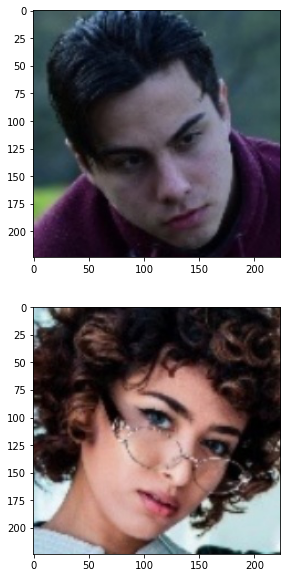

In [106]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(nrows = len(wrong), ncols = 1, figsize=(10,10))

for i, loc in enumerate(wrong.image_path):
    img = mpimg.imread(loc)
    axes[i].imshow(img)